In [13]:
import numpy as np
import tomlkit
import pandas as pd
import yaml
from IPython.display import display
import importlib

import study_lib

In [47]:
importlib.reload(study_lib)
do_run = study_lib.do_run 
get_fields = study_lib.get_fields
run_experiment = study_lib.run_experiment
config_series = study_lib.config_series

In [26]:
base_config_yaml = """
candidates: 5
voters: 13
considerations:
- Likability:
    mean: 0.5
- Irrational:
    sigma: 1.0
    camps: 0
    individualism_deg: 30
- Issues:
    issues:
    - halfcsep: 0.0
      halfvsep: 0.0
      sigma: 1.0
methods:
- Plurality:
    strat: Honest
- Range:
    nranks: 10
    strat: Honest
- Range:
    nranks: 2
    strat: Honest
- Range:
    nranks: 2
    strat: Strategic
- InstantRunoff: {}
- Borda: {}
- Multivote:
    spread_fact: 1.0
    strat: Honest
    votes: 3
- STAR:
    strat: Honest
- STAR:
    strat: Strategic
    strategic_stretch_factor: 1.5
"""
config = yaml.safe_load(base_config_yaml)

In [48]:
config = yaml.safe_load(base_config_yaml)
df = run_experiment(
    config_series(config, 'voters', [7, 9, 11, 13, 15, 51]),
    trials=10000
)
df

,voters,pl_h_mR,pl_h_pi,range_10_h_mR,range_10_h_pi,aprv_h_mR,aprv_h_pi,aprv_s_mR,aprv_s_pi,IRV_h_mR,IRV_h_pi,Borda_h_mR,Borda_h_pi,multi_h_3v_mR,multi_h_3v_pi,star_6_h_mR,star_6_h_pi,star_6_s_mR,star_6_s_pi
0,7,0.115502,77.95,0.027929,89.80,0.065014,83.41,0.075648,82.06,0.113707,78.67,0.053795,85.00,0.086862,80.14,0.058609,84.22,0.072316,82.25
1,9,0.111799,78.62,0.024317,90.39,0.056933,84.93,0.067839,83.31,0.099686,80.05,0.047348,86.01,0.078653,81.34,0.051081,85.32,0.065185,83.09
2,11,0.099685,79.58,0.022170,90.62,0.048333,85.81,0.062765,83.48,0.085742,80.79,0.041893,86.61,0.075776,81.53,0.048077,85.11,0.061368,82.98
3,13,0.100350,80.88,0.018979,91.97,0.048169,86.45,0.061325,84.79,0.087846,82.07,0.040095,87.51,0.070568,82.84,0.043877,86.90,0.057407,84.60
4,15,0.092219,81.86,0.021584,91.39,0.046245,86.65,0.053686,85.32,0.071343,83.68,0.036796,87.94,0.065388,83.57,0.042774,86.89,0.053128,85.23
5,51,0.055659,86.89,0.009463,94.46,0.021311,91.64,0.025822,90.49,0.033728,89.60,0.015975,92.73,0.030876,89.72,0.019029,92.01,0.024350,90.54


More voters makes regrets lower

In [29]:
config = yaml.safe_load(base_config_yaml)
df = run_experiment(
    config_series(config, 'considerations.0.Likability.mean', [0., 0.5, 1.0, 4.0, 40.0]),
    trials=100000
)
df

defaultdict(<class 'list'>, {'Likability': [0.0, 0.5, 1.0, 4.0, 40.0], 'm:pl_h.mR': [np.float64(0.2217632579864919), np.float64(0.09912753751392928), np.float64(0.04855259505785039), np.float64(0.0063878844941593835), np.float64(0.00010486268700400757)], 'm:pl_h.pi': [np.float64(61.973), np.float64(80.607), np.float64(88.729), np.float64(97.151), np.float64(99.721)], 'm:range_10_h.mR': [np.float64(0.044072125164135695), np.float64(0.02068672275634888), np.float64(0.010641136522904706), np.float64(0.0013642725318774504), np.float64(3.796638956906672e-05)], 'm:range_10_h.pi': [np.float64(83.525), np.float64(91.51700000000001), np.float64(94.841), np.float64(98.788), np.float64(99.80799999999999)], 'm:aprv_h.mR': [np.float64(0.09764281981696261), np.float64(0.0482719842721552), np.float64(0.024970567608947655), np.float64(0.005626009982720508), np.float64(0.01301938307487144)], 'm:aprv_h.pi': [np.float64(74.527), np.float64(86.283), np.float64(91.514), np.float64(96.992), np.float64(96.45

,Likability,m:pl_h.mR,m:pl_h.pi,m:range_10_h.mR,m:range_10_h.pi,m:aprv_h.mR,m:aprv_h.pi,m:aprv_s.mR,m:aprv_s.pi,m:IRV_h.mR,m:IRV_h.pi,m:Borda_h.mR,m:Borda_h.pi,m:multi_h_3v.mR,m:multi_h_3v.pi,m:star_6_h.mR,m:star_6_h.pi,m:star_6_s.mR,m:star_6_s.pi
0,0.0,0.221763,61.973,0.044072,83.525,0.097643,74.527,0.117424,71.883,0.194295,64.829,0.081142,76.739,0.137818,69.088,0.088692,74.952,0.112307,71.452
1,0.5,0.099128,80.607,0.020687,91.517,0.048272,86.283,0.057702,84.805,0.087530,81.816,0.039873,87.582,0.068331,83.101,0.044625,86.483,0.056352,84.580
2,1.0,0.048553,88.729,0.010641,94.841,0.024971,91.514,0.029310,90.876,0.043064,89.436,0.020572,92.357,0.036229,89.388,0.022947,91.933,0.029195,90.684
3,4.0,0.006388,97.151,0.001364,98.788,0.005626,96.992,0.004512,97.389,0.005819,97.238,0.003454,97.649,0.012610,95.044,0.003333,97.926,0.004452,97.385
4,40.0,0.000105,99.721,0.000038,99.808,0.013019,96.454,0.000248,99.661,0.000092,99.723,0.000083,99.727,0.033480,92.265,0.000085,99.728,0.000087,99.727


Likability makes voting systems more nearly equivalent.

Not sure why multivoting doesn't do better than this though.

In [30]:
config['considerations'] = [
    {'Likability': {'mean': 1.0}},
]
df = run_experiment(
    config_series(config, 'considerations.0.Likability.mean', [0.5, 1.0, 4.0, 40.0]),
    trials=100000
)
df

defaultdict(<class 'list'>, {'Likability': [0.5, 1.0, 4.0, 40.0], 'm:pl_h.mR': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], 'm:pl_h.pi': [np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0)], 'm:range_10_h.mR': [np.float64(1.8030300570257226e-05), np.float64(1.832433206741117e-05), np.float64(1.957019854899287e-05), np.float64(1.3402433357576518e-05)], 'm:range_10_h.pi': [np.float64(99.967), np.float64(99.969), np.float64(99.969), np.float64(99.976)], 'm:aprv_h.mR': [np.float64(0.01746301859518136), np.float64(0.017861336655946903), np.float64(0.018271926593190872), np.float64(0.01830841762526326)], 'm:aprv_h.pi': [np.float64(95.792), np.float64(95.70100000000001), np.float64(95.61500000000001), np.float64(95.636)], 'm:aprv_s.mR': [np.float64(0.0005573896656196814), np.float64(0.000624433084317611), np.float64(0.0006137940760675954), np.float64(0.0005671926663926622)], 'm:aprv_s.pi': [np.float64(99.863), np.float64(99.834), np.float64(99.

,Likability,m:pl_h.mR,m:pl_h.pi,m:range_10_h.mR,m:range_10_h.pi,m:aprv_h.mR,m:aprv_h.pi,m:aprv_s.mR,m:aprv_s.pi,m:IRV_h.mR,m:IRV_h.pi,m:Borda_h.mR,m:Borda_h.pi,m:multi_h_3v.mR,m:multi_h_3v.pi,m:star_6_h.mR,m:star_6_h.pi,m:star_6_s.mR,m:star_6_s.pi
0,0.5,0.0,100.0,0.000018,99.967,0.017463,95.792,0.000557,99.863,0.0,100.0,0.0,100.0,0.045033,90.543,0.000101,99.888,0.0,100.0
1,1.0,0.0,100.0,0.000018,99.969,0.017861,95.701,0.000624,99.834,0.0,100.0,0.0,100.0,0.045028,90.383,0.000085,99.907,0.0,100.0
2,4.0,0.0,100.0,0.000020,99.969,0.018272,95.615,0.000614,99.838,0.0,100.0,0.0,100.0,0.045902,90.253,0.000112,99.898,0.0,100.0
3,40.0,0.0,100.0,0.000013,99.976,0.018308,95.636,0.000567,99.847,0.0,100.0,0.0,100.0,0.045456,90.354,0.000104,99.905,0.0,100.0


Above is a test of pure likability. This uncovered a serious bug. Likability originally wasn't adding to scores, it was overwriting them. I should design the code better, probably.

It makes sense that plurality, IRV, and Borda all give perfect scores. In this scenario, all voters have the same scores and issue the same ballots. Range, approval, multivoting, and star can all give ties.

In [50]:
config = yaml.safe_load(base_config_yaml)
df = run_experiment(
    config_series(config, 'considerations.1.Irrational.sigma', [0., 0.5, 2.0, 4.0, 40.0]),
    trials=100000
)
df

,Irrational,pl_h_mR,pl_h_pi,range_10_h_mR,range_10_h_pi,aprv_h_mR,aprv_h_pi,aprv_s_mR,aprv_s_pi,IRV_h_mR,IRV_h_pi,Borda_h_mR,Borda_h_pi,multi_h_3v_mR,multi_h_3v_pi,star_6_h_mR,star_6_h_pi,star_6_s_mR,star_6_s_pi
0,0.0,0.088142,83.275,0.025840,91.049,0.060397,84.043,0.058007,84.652,0.075646,83.921,0.053598,85.660,0.105496,78.727,0.044233,87.806,0.060188,84.422
1,0.5,0.076228,84.811,0.017029,92.644,0.036559,88.107,0.036788,88.650,0.061803,86.253,0.028627,89.864,0.051197,85.644,0.029299,89.953,0.036064,88.540
2,2.0,0.162902,72.402,0.032161,88.465,0.081104,80.827,0.099183,78.439,0.148170,74.033,0.065270,82.870,0.112318,76.919,0.075562,80.613,0.095791,77.953
3,4.0,0.236839,64.053,0.045187,85.532,0.112543,75.801,0.142942,72.271,0.213382,66.420,0.093799,78.041,0.155014,70.932,0.104954,75.351,0.134491,71.918
4,40.0,0.309784,56.465,0.053806,83.544,0.131322,73.043,0.178686,67.644,0.273375,59.757,0.121484,74.024,0.181624,67.713,0.129472,71.227,0.165224,67.358


Irrational voters make everything tougher.

In [51]:
config = yaml.safe_load(base_config_yaml)
config['considerations'] = config['considerations'][1:2]  # Irr only
df = run_experiment(
    config_series(config, 'considerations.0.Irrational.camps', [0, 2, 3, 4, 5]),
    trials=100000
)
df

,Irrational,pl_h_mR,pl_h_pi,range_10_h_mR,range_10_h_pi,aprv_h_mR,aprv_h_pi,aprv_s_mR,aprv_s_pi,IRV_h_mR,IRV_h_pi,Borda_h_mR,Borda_h_pi,multi_h_3v_mR,multi_h_3v_pi,star_6_h_mR,star_6_h_pi,star_6_s_mR,star_6_s_pi
0,0,0.309087,56.588,0.054973,83.466,0.131475,72.889,0.180664,67.591,0.275175,59.536,0.122163,73.941,0.186569,66.997,0.129307,71.517,0.166367,67.403
1,2,0.159376,73.385,0.019758,91.165,0.041736,85.509,0.055042,84.381,0.126008,76.698,0.036159,86.956,0.061101,82.354,0.042748,86.345,0.055851,83.812
2,3,0.178391,69.307,0.030188,88.456,0.059945,82.407,0.093662,78.009,0.151855,71.901,0.052787,83.702,0.085185,78.722,0.071024,80.531,0.090792,77.575
3,4,0.194256,67.174,0.035537,87.134,0.071876,80.675,0.102528,76.286,0.165357,70.193,0.064243,81.764,0.101783,76.514,0.081067,78.483,0.100210,75.819
4,5,0.212370,65.584,0.040501,86.206,0.083329,79.120,0.116674,74.763,0.185672,68.478,0.073799,80.286,0.118791,74.406,0.091064,77.140,0.114156,74.222


In [52]:
config = yaml.safe_load(base_config_yaml)
# Have to do this as one experiment, since number of votes is part of the column name.
# Also it's more efficient this way.
config['methods'].extend(yaml.safe_load('''
- Multivote:
    spread_fact: 1.0
    strat: Honest
    votes: 2
- Multivote:
    spread_fact: 1.0
    strat: Honest
    votes: 4
'''))
config['considerations'][0]['Likability']['mean'] = 0.1  # damp this a lot
config['considerations'][2]['Issues']['issues'][0]['sigma'] = 0.25  # Also damped
df = run_experiment([config], trials=1000000)
df

,config_num,pl_h_mR,pl_h_pi,range_10_h_mR,range_10_h_pi,aprv_h_mR,aprv_h_pi,aprv_s_mR,aprv_s_pi,IRV_h_mR,...,multi_h_3v_mR,multi_h_3v_pi,star_6_h_mR,star_6_h_pi,star_6_s_mR,star_6_s_pi,multi_h_2v_mR,multi_h_2v_pi,multi_h_4v_mR,multi_h_4v_pi
0,0,0.250367,62.4599,0.047579,84.9139,0.117002,75.0007,0.150424,71.1285,0.2256,...,0.160792,70.1184,0.110647,74.34,0.141062,70.8185,0.180802,68.2498,0.134033,73.2127


In [57]:
data = [
    ['Plurality', df.pl_h_mR[0]],
    ['IRV', df.IRV_h_mR[0]],
    ['Approval', df.aprv_h_mR[0]],
    ['Multivoting, 2', df.multi_h_2v_mR[0]],
    ['Multivoting, 3', df.multi_h_3v_mR[0]],
    ['Borda', df.Borda_h_mR[0]],
    ['Range 1-10', df.range_10_h_mR[0]],
    # ['STAR', df.star_6_h_mR[0]],
]
data_x = [p[0] for p in data]
data_y = [(1.0 - p[1]) * 100. for p in data]

| Plurality | IRV | Approval | Multi 

In [58]:
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

[<BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>]


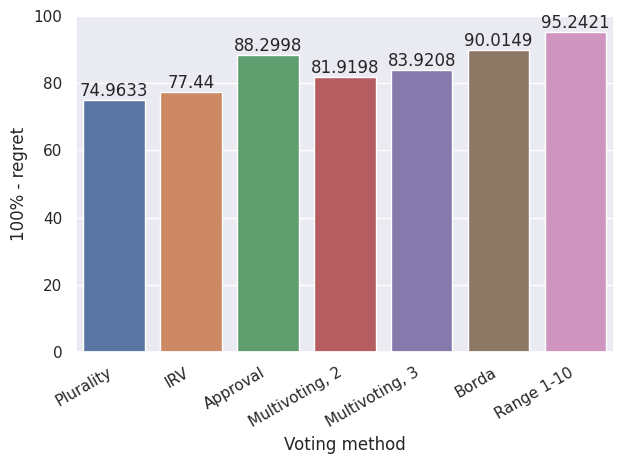

In [59]:
ax = sns.barplot(x=data_x, y=data_y, errorbar=None, hue=data_x, legend=False)
plt.xlabel('Voting method')
plt.ylabel('100% - regret')
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
print(ax.containers)
for i in range(len(data_x)):
    ax.bar_label(ax.containers[i])

[<BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>]


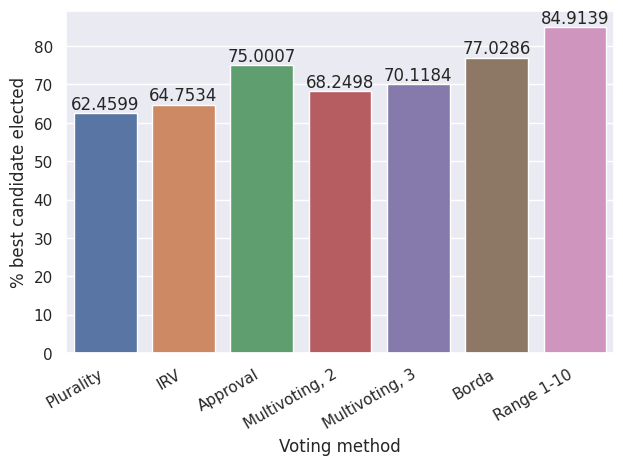

In [62]:
data = [
    ['Plurality', df.pl_h_pi[0]],
    ['IRV', df.IRV_h_pi[0]],
    ['Approval', df.aprv_h_pi[0]],
    ['Multivoting, 2', df.multi_h_2v_pi[0]],
    ['Multivoting, 3', df.multi_h_3v_pi[0]],
    ['Borda', df.Borda_h_pi[0]],
    ['Range 1-10', df.range_10_h_pi[0]],
    #['STAR', df.star_6_h_pi[0]],
]
data_x = [p[0] for p in data]
data_y = [p[1] for p in data]
ax = sns.barplot(x=data_x, y=data_y, errorbar=None, hue=data_x, legend=False)
plt.xlabel('Voting method')
plt.ylabel('% best candidate elected')
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
print(ax.containers)
for i in range(len(data_x)):
    ax.bar_label(ax.containers[i])